In [18]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_yearly, plot_forecast_component
from time import strptime, strftime
from funcs import *

# Spend Data

In [76]:
raw14 = pd.read_excel('SpendMonthlyStraight2014.xlsx', skiprows=range(3), index_col=0)
raw15 = pd.read_excel('SpendMonthlyStraight2015.xlsx', skiprows=range(4), index_col=0)
raw16 = pd.read_excel('SpendMonthlyStraight2016.xlsx')
raw17 = pd.read_excel('SpendMonthlyStraight2017.xlsx')

In [61]:
raw14.head()

,Brand,Budget,1st part invoice,2nd part invoice,Accrual,Spend (1st pt + accrued),Actuals,Variance (Act vs Accr),Budget.1,1st part invoice.1,...,Spend (1st pt + accrued).10,Actuals.10,Variance.9,Budget.11,1st part invoice.11,2nd part invoice.11,Accrual.11,Spend (1st pt + accrued).11,Actuals.11,Variance.10
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LLK,Online,150000.0,75000.0,80989.34,95000.0,170000.0,155989.34,14010.66,170000.0,90000.0,...,175000.0,175006.73,-6.73,190000.0,95000.0,95745.23,98000.0,193000.0,190745.23,2254.77
LLK,Print,110000.0,55000.0,54566.56,55000.0,110000.0,109566.56,433.44,102000.0,51000.0,...,120000.0,120570.17,-570.17,123000.0,61500.0,60100.65,60100.0,121600.0,121600.65,-0.65
LLK,TV,280000.0,140000.0,132503.05,130000.0,270000.0,272503.05,-2503.05,270000.0,135000.0,...,370000.0,366481.32,3518.68,300000.0,150000.0,143618.83,143700.0,293700.0,293618.83,81.17
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
raw15.head()

,Brand,Budget,1st part invoice,2nd part invoice,Accrual,Spend (1st pt + accrued),Actuals,Variance (Act vs Accr),Budget.1,1st part invoice.1,...,Spend (1st pt + accrued).10,Actuals.10,Variance.9,Budget.11,1st part invoice.11,2nd part invoice.11,Accrual.11,Spend (1st pt + accrued).11,Actuals.11,Variance.10
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LLK,Online,170000.0,85000.0,147615.21,147620.0,232620.0,232615.21,4.79,255000.0,127500.0,...,214639.69,213950.09,689.6,245000.0,122500.0,104760.18,0.0,122500.0,227260.18,-17739.82
LLK,Print,100000.0,50000.0,74380.75,74381.0,124381.0,124380.75,0.25,100000.0,50000.0,...,121596.38,120178.88,1417.5,122000.0,61000.0,72298.41,0.0,61000.0,133298.41,11298.41
LLK,TV,240000.0,120000.0,157407.18,158505.0,278505.0,277407.18,1097.82,319000.0,159500.0,...,248615.45,243907.45,4708.0,300000.0,150000.0,69124.83,0.0,150000.0,219124.83,-80875.17
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
raw15 = raw15.dropna(how='all')
raw14 = raw14.dropna(how='all')

Each column is repeated 12 times: here's a function that gives list of columns corresp. to months Jan-Dec:

In [21]:
monthlist = lambda x: [x] + [ x + '.' + str(k) for k in range(1,12)]    

In [65]:
raw14.loc['LLK',:][monthlist('Actuals')]

,Actuals,Actuals.1,Actuals.2,Actuals.3,Actuals.4,Actuals.5,Actuals.6,Actuals.7,Actuals.8,Actuals.9,Actuals.10,Actuals.11
LLK,155989.34,171562.91,180592.86,169938.07,172682.80,184898.74,175739.22,186924.93,186090.21,180026.42,175006.73,190745.23
LLK,109566.56,88107.76,113043.73,111548.43,110964.50,107016.01,113555.02,114933.12,113263.30,128836.27,120570.17,121600.65
LLK,272503.05,267610.54,291644.38,270549.48,269160.55,295801.40,302167.44,311702.14,269706.06,270812.54,366481.32,293618.83


In [84]:
# Note: offset alias 'MS' gives beginning of every month.
#       We may want to eg. spread the spend over the month..?

months = lambda year: pd.date_range(start=year+"-01-01", freq="MS", periods=12)
brands = raw15.index.unique().tolist()[1:]

In [85]:
dat = raw15[monthlist('Actuals')].groupby(raw15.index)
spend15 = dat.sum().T
spend15.rename(index={monthlist('Actuals')[i]: months('2015')[i] for i in range(12)}, inplace=True)

dat = raw14[monthlist('Actuals')].groupby(raw14.index)
spend14 = dat.sum().T
spend14.rename(index={monthlist('Actuals')[i]: months('2014')[i] for i in range(12)}, inplace=True)

In [86]:
spend15.head()

,FONO,GSV,IML,LBL,LLK,MM,RDL,TGO,VBL
2015-01-01,105601.61,43601.81,10399.88,587.94,634403.14,106403.62,45372.56,185.62,18104.50
2015-02-01,88844.24,39882.00,16264.85,506.70,607560.66,93871.09,43840.17,608.14,15479.43
2015-03-01,119813.34,55658.49,25923.88,511.01,686881.79,94677.18,40820.44,607.91,15774.03
2015-04-01,116011.97,51700.30,35302.03,508.62,627036.35,108734.97,35666.32,608.40,17227.73
2015-05-01,127184.42,47122.51,35072.94,509.75,679980.95,93167.35,31409.50,607.92,14991.26


In [87]:
spend14.head()

,FONO,GS App,GSV,IML,LLK,RDL,VBL
2014-01-01,85221.89,0.0,60770.07,9461.04,538058.95,61220.23,22363.66
2014-02-01,84837.17,0.0,56698.15,7649.88,527281.21,48238.97,19102.80
2014-03-01,92628.65,0.0,59685.11,7586.24,585280.97,50694.91,19105.14
2014-04-01,97696.45,0.0,72001.22,8352.52,552035.98,51329.79,20338.63
2014-05-01,91160.62,0.0,75381.85,9373.06,552807.85,50396.27,21989.78


In [88]:
spend16 = raw16.T.rename(index={raw16.T.index[i]: months('2016')[i] for i in range(12)})
spend17 = raw17.T.rename(index={raw17.T.index[i]: months('2017')[i] for i in range(12)})

In [112]:
spend16.head()

,LLK,FONO,CDL,VBL
2016-01-01,643000,112000,39000,18000
2016-02-01,583000,100000,39000,18000
2016-03-01,608000,100000,39000,18000
2016-04-01,568000,100000,39000,18000
2016-05-01,648000,112000,39000,18000


Concatenate all spend data; drop empty 'GS App' column:

In [104]:
spend = pd.concat([spend14, spend15, spend16,spend17], sort=True).drop(columns=['GS App'])

In [105]:
spend.columns

Index(['CDL', 'FONO', 'GSV', 'IML', 'LBL', 'LLK', 'MM', 'RDL', 'TGO', 'VBL'], dtype='object')

In [109]:
spend.head()

,CDL,FONO,GSV,IML,LBL,LLK,MM,RDL,TGO,VBL
2014-01-01,NaN,85221.89,60770.07,9461.04,NaN,538058.95,NaN,61220.23,NaN,22363.66
2014-02-01,NaN,84837.17,56698.15,7649.88,NaN,527281.21,NaN,48238.97,NaN,19102.80
2014-03-01,NaN,92628.65,59685.11,7586.24,NaN,585280.97,NaN,50694.91,NaN,19105.14
2014-04-01,NaN,97696.45,72001.22,8352.52,NaN,552035.98,NaN,51329.79,NaN,20338.63
2014-05-01,NaN,91160.62,75381.85,9373.06,NaN,552807.85,NaN,50396.27,NaN,21989.78


In [159]:
# Brand Names:
{'LLK': 'LiveLinks', 'FONO': 'Fonochat', 'RDL': 'Redhot', 'VBL': 'Vibeline', 'IML': 'InteractiveMale', 
 'TGO': 'TangoPersonals', 'LBL': 'LavenderLine', 'GSV': 'GuySpy Voice', 'MM': 'MegaMates'}

{'LLK': 'LiveLinks',
 'FONO': 'Fonochat',
 'RDL': 'Redhot',
 'VBL': 'Vibeline',
 'IML': 'InteractiveMale',
 'TGO': 'TangoPersonals',
 'LBL': 'LavenderLine',
 'GSV': 'GuySpy Voice',
 'MM': 'MegaMates'}

In [115]:
brands

['LLK', 'FONO', 'RDL', 'VBL', 'IML', 'TGO', 'LBL', 'GSV', 'MM']

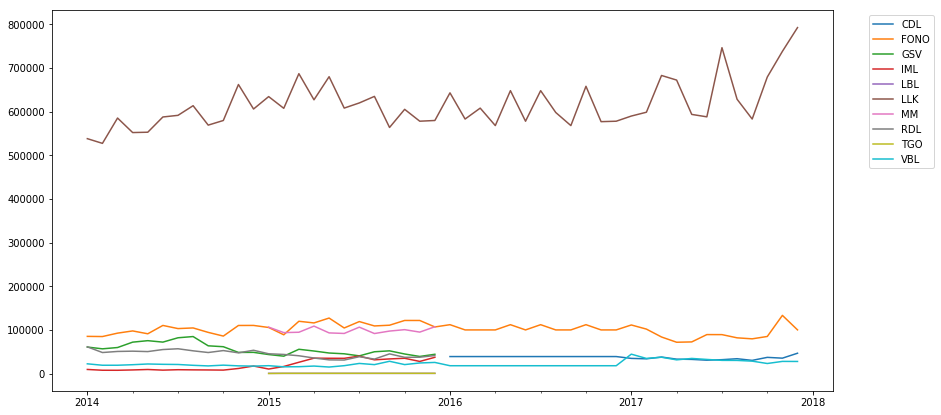

In [114]:
spend.plot(legend=False, figsize=(14,7))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# Revenue and Calls Data

In [142]:
revdaily=pd.read_excel('RevenueDailyAllBrands010110-120918.xls', skiprows=[0,2], index_col=0)
revdaily.head()

,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
2010-01-01,15301.998379,10722.7896,NaN,37223.633244,69828.849695,9437.170489,11018.240056
2010-01-02,14130.268201,10922.9006,NaN,35465.973485,71836.647957,9647.400147,8650.354948
2010-01-03,13011.070337,9049.0054,NaN,27983.239376,59105.720264,8854.730920,7687.534200
2010-01-04,12170.568265,9969.6046,NaN,28134.619050,52165.671811,7823.705680,7739.614541
2010-01-05,11165.066732,9959.5188,NaN,25836.434112,56016.956238,7828.667478,7067.524485


Index is already datetime format. Great.

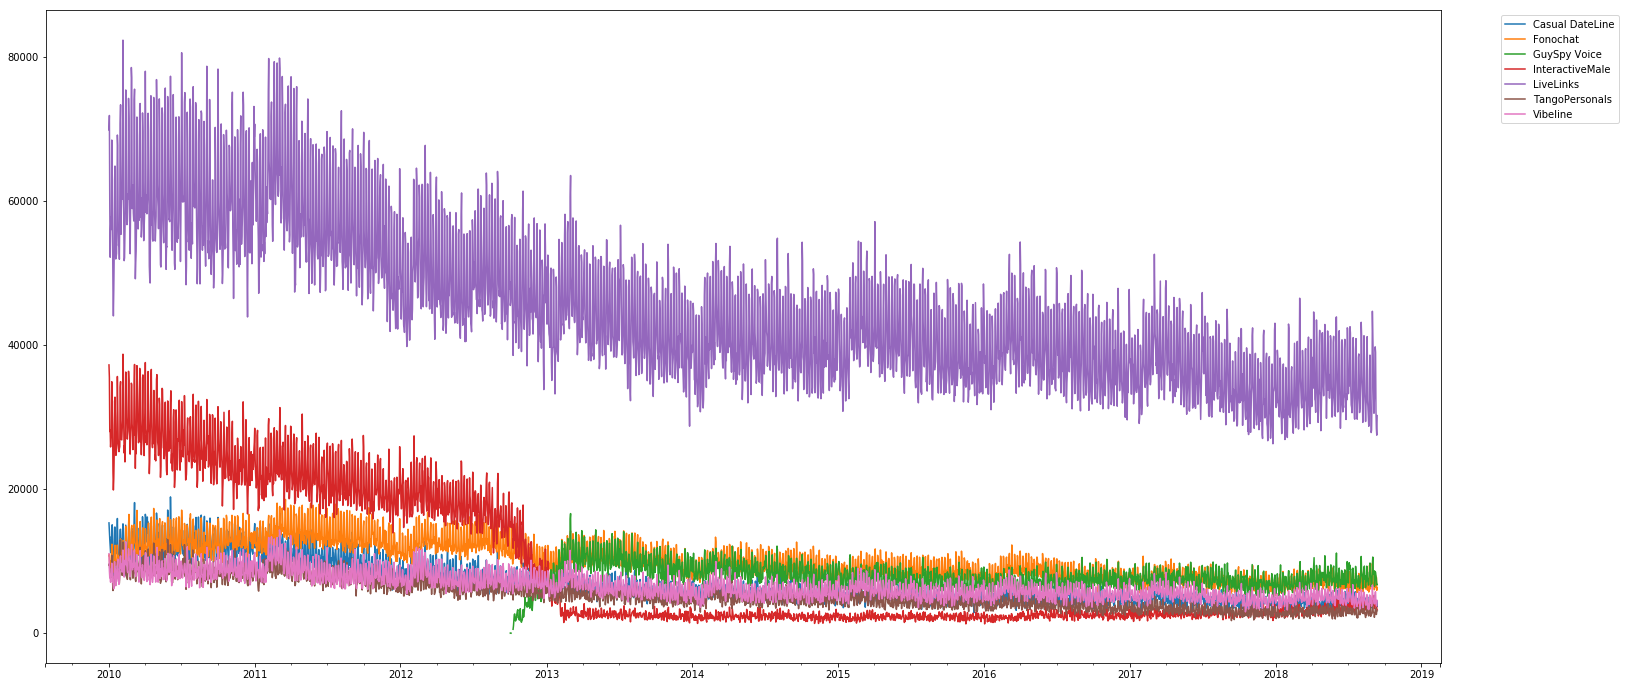

In [152]:
revdaily.plot(legend=False, figsize=(25,12))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

(-1000, 60000)

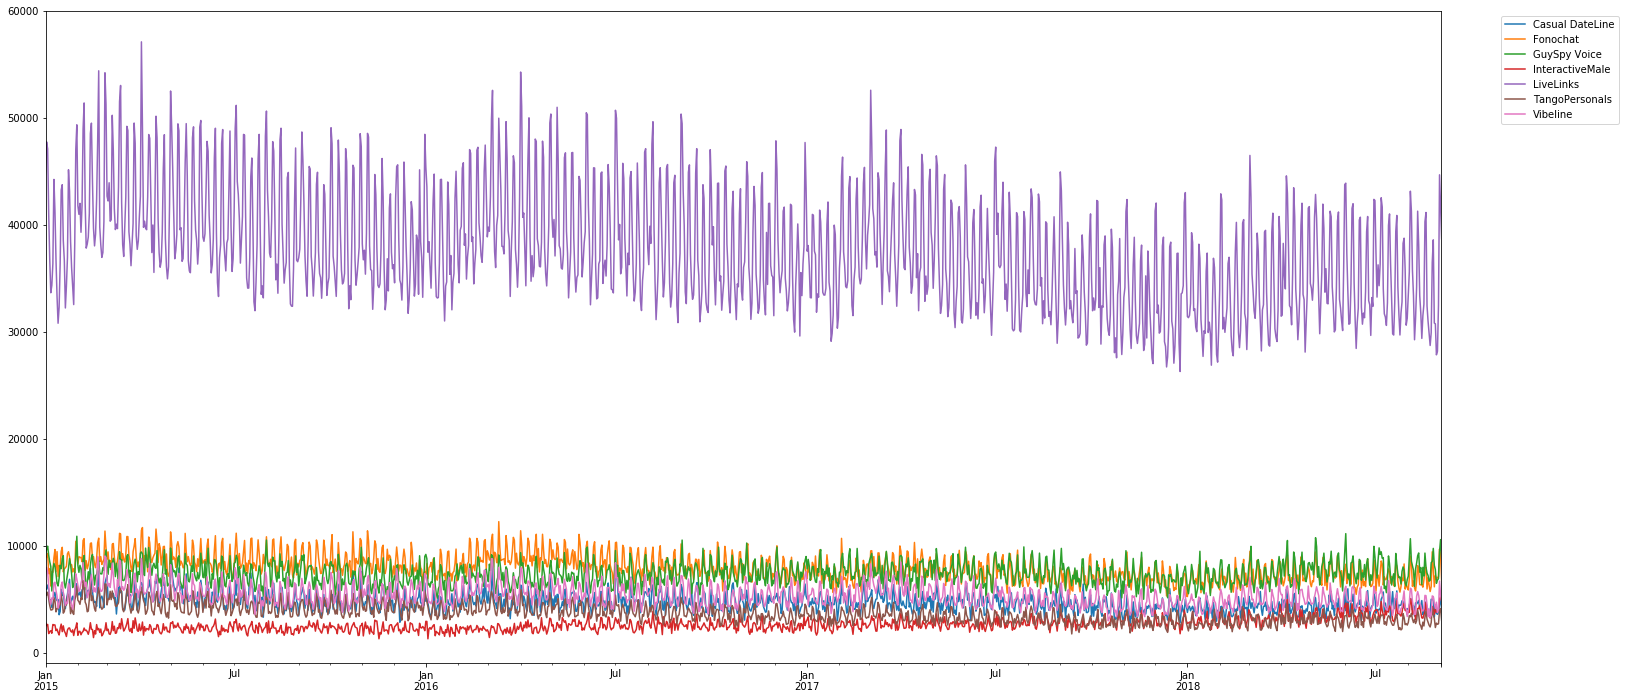

In [157]:
revdaily.plot(legend=False, figsize=(25,12))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().set_xlim(pd.Timestamp('2015-01'), pd.Timestamp('2018-09'))
plt.gca().set_ylim(-1000, 60000)

(0, 35000)

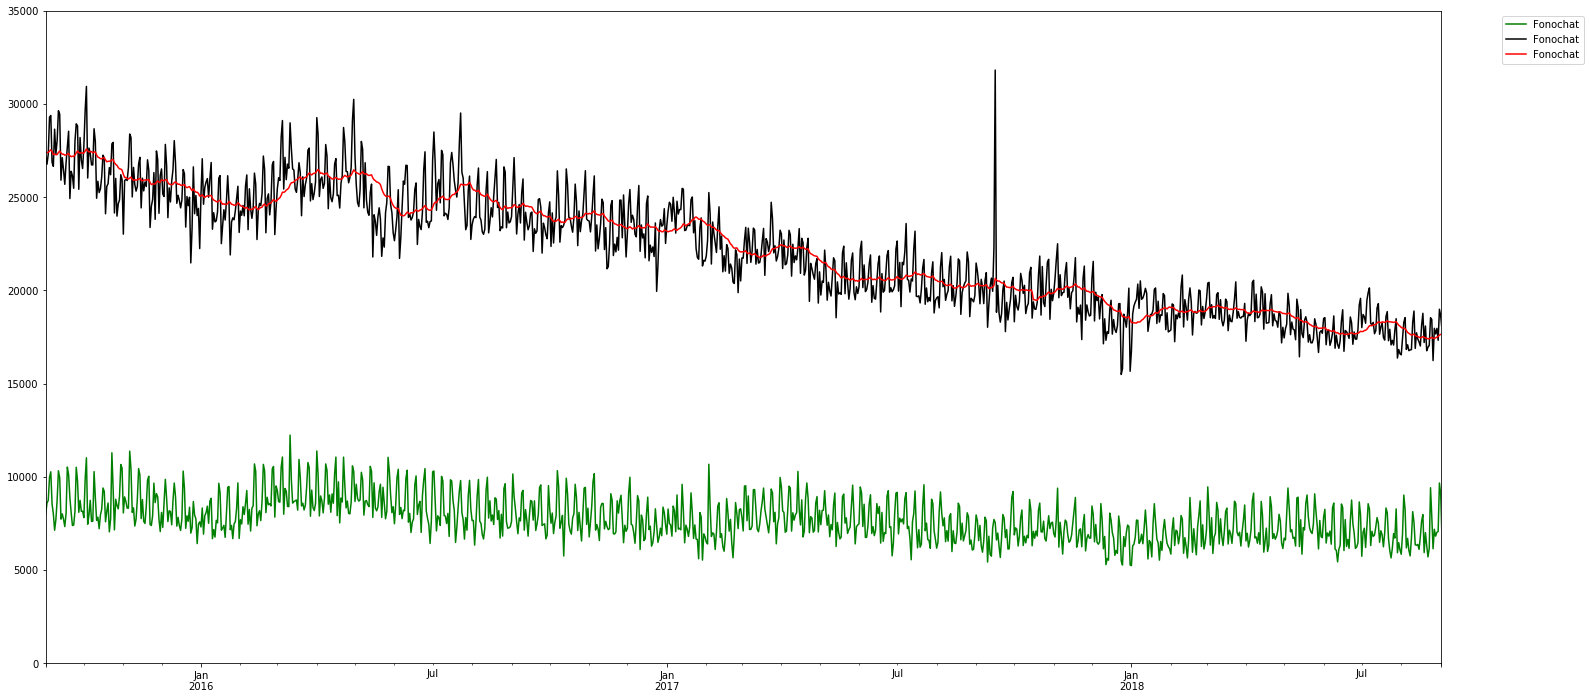

In [189]:
revdaily['Fonochat'].plot(color='green', legend=False, figsize=(25,12))
callsdaily['Fonochat'].plot(color='black')
callsdaily['Fonochat'].rolling(30).mean().plot(color='red')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().set_xlim(pd.Timestamp('2015-09'), pd.Timestamp('2018-09'))
plt.gca().set_ylim(0, 35000)

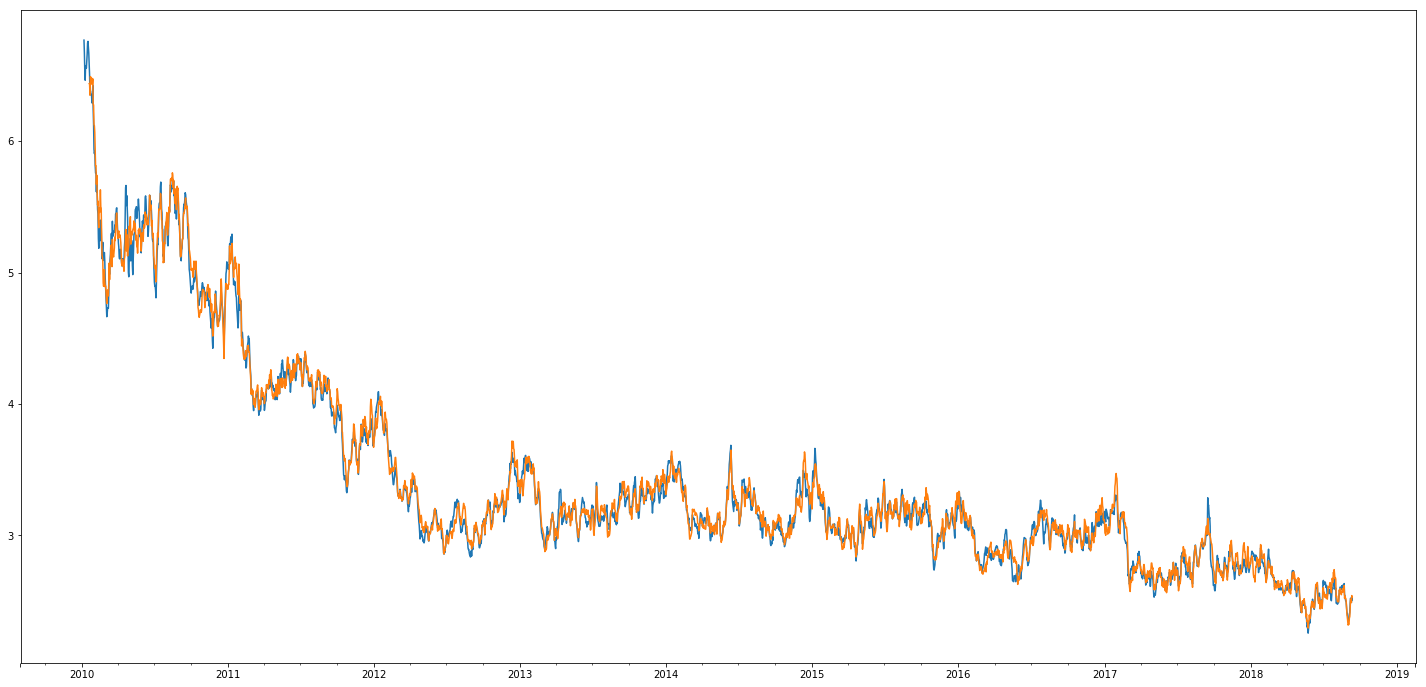

In [218]:
a, b, c, d = [7, 7, 20, 7]
calls_rev_ratio = callsdaily['Fonochat'].rolling(a).mean().divide(revdaily['Fonochat'].rolling(b).mean())
calls_rev_ratio2 = callsdaily['Fonochat'].rolling(c).mean().divide(revdaily['Fonochat'].rolling(d).mean())
calls_rev_ratio.plot(legend=False, figsize=(25,12))
calls_rev_ratio2.plot()

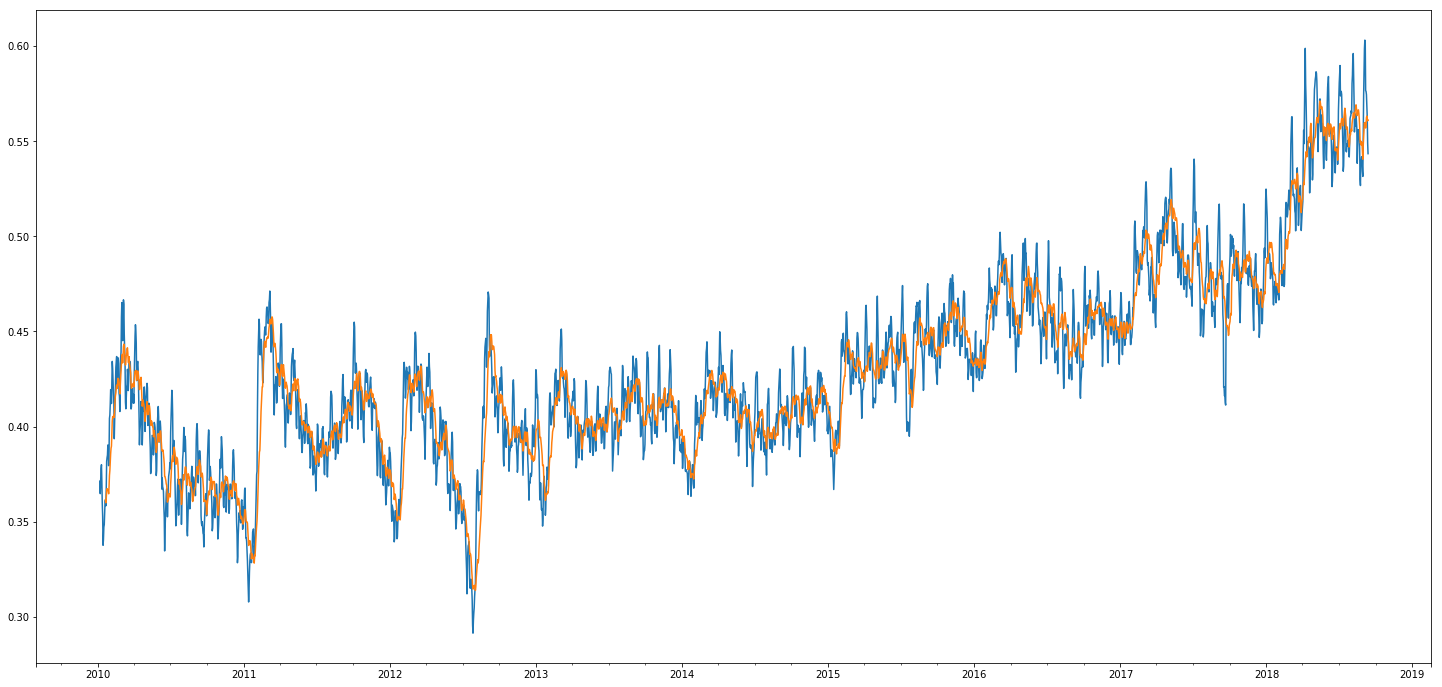

In [214]:
calls_rev_ratio = 1/callsdaily['LiveLinks'].rolling(a).mean().divide(revdaily['LiveLinks'].rolling(b).mean())
calls_rev_ratio2 = 1/callsdaily['LiveLinks'].rolling(c).mean().divide(revdaily['LiveLinks'].rolling(d).mean())
calls_rev_ratio.plot(legend=False, figsize=(25,12))
calls_rev_ratio2.plot()

In [179]:
callsdaily['Fonochat'].tail()

2018-12-27   NaN
2018-12-28   NaN
2018-12-29   NaN
2018-12-30   NaN
2018-12-31   NaN
Name: Fonochat, dtype: float64

In [111]:
months = pd.date_range(start="2015-01-01", freq="MS", periods=12)
SpendStraight15.iloc[1,4:-1:7].values==months

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [148]:
callsdaily = pd.read_excel('CallsDailyAllBrands010110-120918.xls', skiprows=[0,2], index_col=0)
callsdaily.head()

,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
2010-01-01,41273.0,66223.0,NaN,77898.0,173154.0,43189.0,65178.0
2010-01-02,42850.0,70981.0,NaN,78745.0,187857.0,44969.0,69988.0
2010-01-03,40941.0,66484.0,NaN,71970.0,170024.0,42873.0,67630.0
2010-01-04,39742.0,65040.0,NaN,69608.0,155592.0,41776.0,62155.0
2010-01-05,39678.0,70436.0,NaN,68243.0,147995.0,40647.0,61274.0


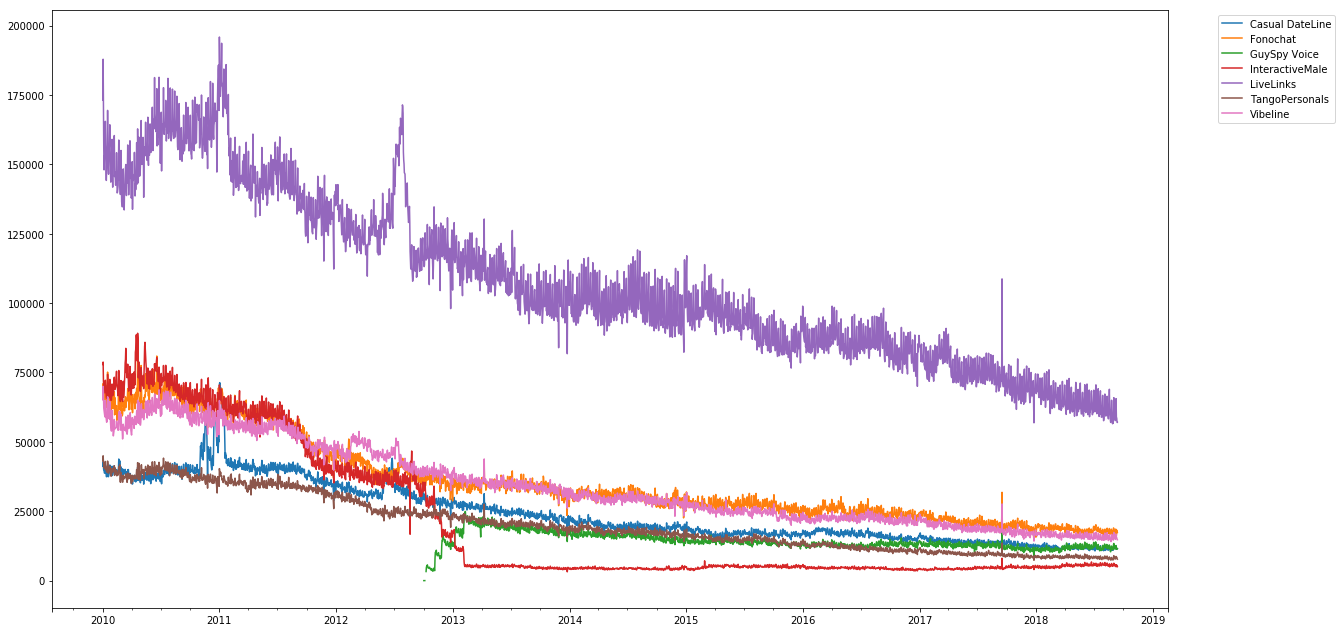

In [150]:
callsdaily.plot(legend=False, figsize=(20,11))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [ ]:
df = pd.read_excel('revenue.xls', skiprows=[0,2])
df.fillna(0, inplace=True)

In [ ]:
df.drop(range(103,108),inplace=True)

Rename the date column using df.rename(columns=dict, inplace=True)
Note: this syntax for merging dicts x, y is new to python 3.5:  z = {**x, **y} 

Format the date column as YYYY-MM string, then convert to datetime:

In [7]:
df.rename(columns={**{'Unnamed: 0': 'Date'}, **{df.columns[k]: df.columns[k] for k in range(1, len(df.columns)) }}, inplace=True)

df['Date'] = df['Date'].apply(lambda x: x[2:7] + str(strptime(x[-3::],"%b").tm_mon).zfill(2))

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

A quick plot of the data:

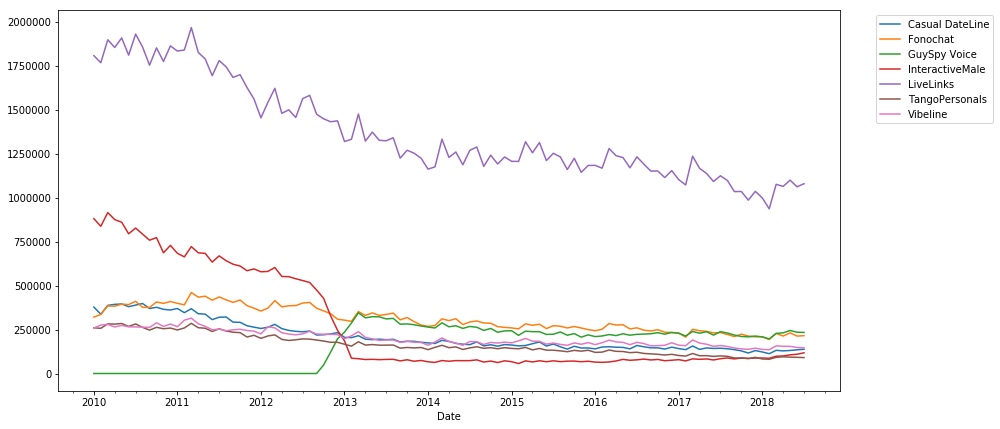

In [11]:
df.plot(legend=False, figsize=(14,7))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [12]:
df['totalrev'] = df.sum(axis='columns')

In [21]:
gross, gross_forecast = fitandforecast(df, 'totalrev')

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(0, 4000000)

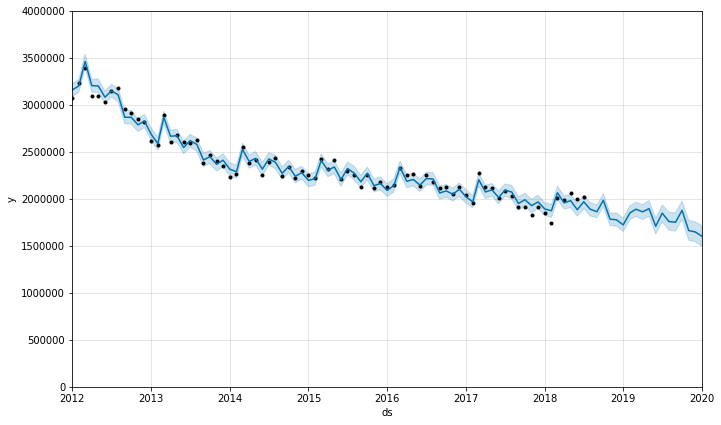

In [22]:
fig_gross = gross.plot(gross_forecast)
gross_ax = plt.gca()
gross_ax.set_xlim(pd.Timestamp('2012'), pd.Timestamp('2020'))
gross_ax.set_ylim([0,4000000])

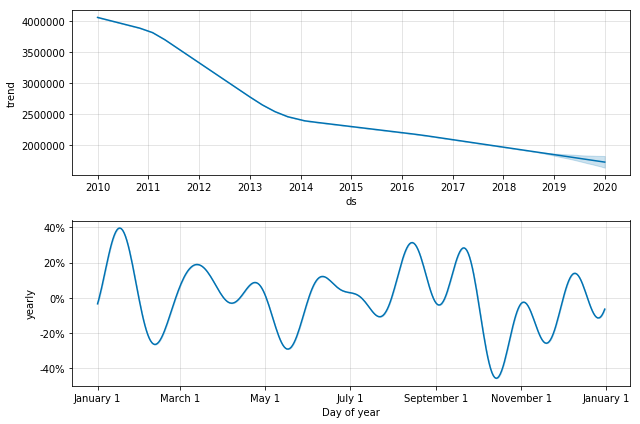

In [23]:
gross_comps=gross.plot_components(gross_forecast)

In [24]:
gross_forecast[gross_forecast['ds'] >= pd.to_datetime('2012-01-01')].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
24,2012-01-01,3.334436e+06,3.088393e+06,3.227619e+06,3.334436e+06,3.334436e+06,-0.052887,-0.052887,-0.052887,-0.052887,-0.052887,-0.052887,0.0,0.0,0.0,3.158086e+06
25,2012-02-01,3.287681e+06,3.134409e+06,3.268279e+06,3.287681e+06,3.287681e+06,-0.025900,-0.025900,-0.025900,-0.025900,-0.025900,-0.025900,0.0,0.0,0.0,3.202529e+06
26,2012-03-01,3.243943e+06,3.394497e+06,3.541635e+06,3.243943e+06,3.243943e+06,0.067316,0.067316,0.067316,0.067316,0.067316,0.067316,0.0,0.0,0.0,3.462313e+06
27,2012-04-01,3.197205e+06,3.133774e+06,3.273101e+06,3.197205e+06,3.197205e+06,0.002258,0.002258,0.002258,0.002258,0.002258,0.002258,0.0,0.0,0.0,3.204424e+06
28,2012-05-01,3.151974e+06,3.133610e+06,3.275917e+06,3.151974e+06,3.151974e+06,0.015752,0.015752,0.015752,0.015752,0.015752,0.015752,0.0,0.0,0.0,3.201625e+06


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(0, 500000)

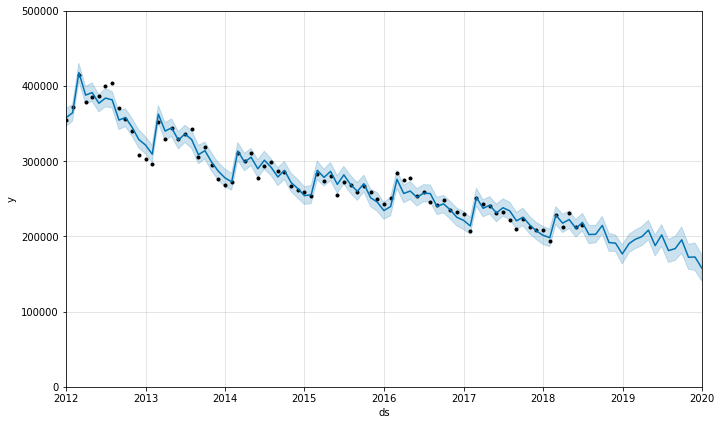

In [25]:
fono, fono_forecast = fitandforecast(df, 'Fonochat')
fig_fono = fono.plot(fono_forecast)
fono_ax = plt.gca()
fono_ax.set_xlim(pd.Timestamp('2012'), pd.Timestamp('2020'))
fono_ax.set_ylim([0,500000])

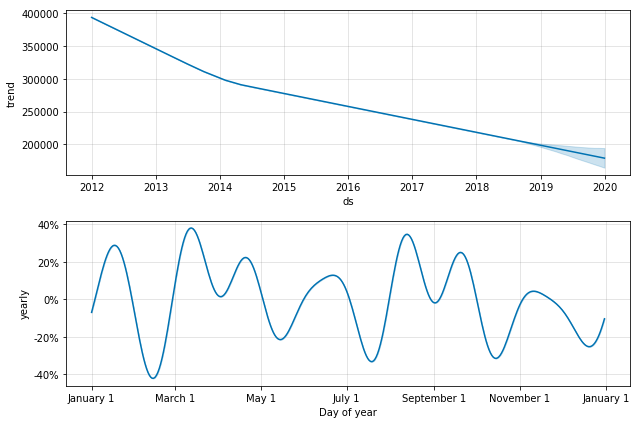

In [26]:
fono_comps = fono.plot_components(fono_forecast[fono_forecast['ds'] >= pd.to_datetime('2012-01-01')])

### Effect of Fourier order on seasonality (totalrev)